**About Dataset**
**Context**
There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

**Content**
PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

**NOTE: Transactions which are detected as fraud are cancelled, so for fraud detection these columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) must not be used.**

Headers
This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount -**
amount of the transaction in local currency.

**nameOrig -** customer who started the transaction

**oldbalanceOrg -** initial balance before the transaction

**newbalanceOrig -** new balance after the transaction.

nameDest **bold text**- customer who is the recipient of the transaction

**oldbalanceDest -** initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest -** new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud - **This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud -** The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

Past Research
There are 5 similar files that contain the run of 5 different scenarios. These files are better explained at my PhD thesis chapter 7 (PhD Thesis Available here http://urn.kb.se/resolve?urn=urn:nbn:se:bth-12932.

We ran PaySim several times using random seeds for 744 steps, representing each hour of one month of real time, which matches the original logs. Each run took around 45 minutes on an i7 intel processor with 16GB of RAM. The final result of a run contains approximately 24 million of financial records divided into the 5 types of categories: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.


In [1]:
! pip install pandas

In [2]:
import os
import gc
import warnings
warnings.simplefilter("ignore")
SEED = 42

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter

import seaborn as sns

# 1) Load & inspect data

In [3]:
df = pd.read_csv(r"/content/PS_20174392719_1491204439457_log.csv")

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
print("Shape:", df.shape)

Shape: (6362620, 11)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.describe(include='all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1530544995,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00


In [8]:
df['isFraud'].isnull().sum()

np.int64(0)

Quick glance at class distribution

In [9]:
# Quick glance at class distribution (fraud column in PaySim is usually 'isFraud' or 'isFlaggedFraud')


# Confirm column names and adjust below if different.

# Detect which column in your dataset represents fraud labels (e.g., isFraud or isFlaggedFraud).
# Set that as the target variable.
# Display how many fraudulent vs. non-fraudulent transactions are present in the dataset.


# check fraud label column

if 'isFraud' in df.columns:
    target_col = 'isFraud'
elif 'isflag' in df.columns:
    target_col = 'isflag'
elif 'isFlaggedFraud' in df.columns:
    target_col = 'isFlaggedFraud'
else:
    # Adjust manually if dataset differs
    target_col = 'isFraud'  # change if needed

print("Target column used:", target_col)

print("Count fraud vs non-fraud")
print(df[target_col].value_counts())

print("Show class proportion")
print(df[target_col].value_counts(normalize=True))

Target column used: isFraud
Count fraud vs non-fraud
isFraud
0    6354407
1       8213
Name: count, dtype: int64
Show class proportion
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


# 2) Visualize basic distributions

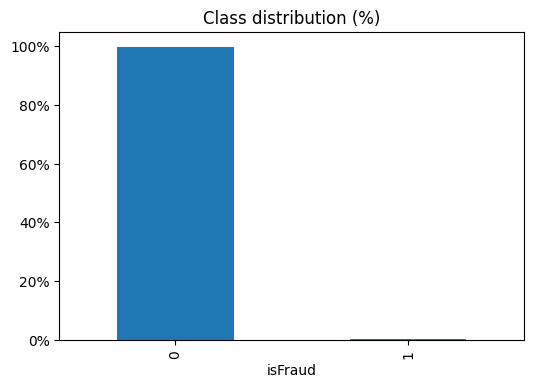

In [10]:
import matplotlib.ticker as mtick
plt.figure(figsize=(6,4))
(df[target_col].value_counts(normalize=True) * 100).plot(kind='bar')
plt.title('Class distribution (%)')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [11]:
# Histograms for numeric features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove(target_col) if target_col in num_cols else None
print("Numeric columns:", num_cols)


Numeric columns: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']


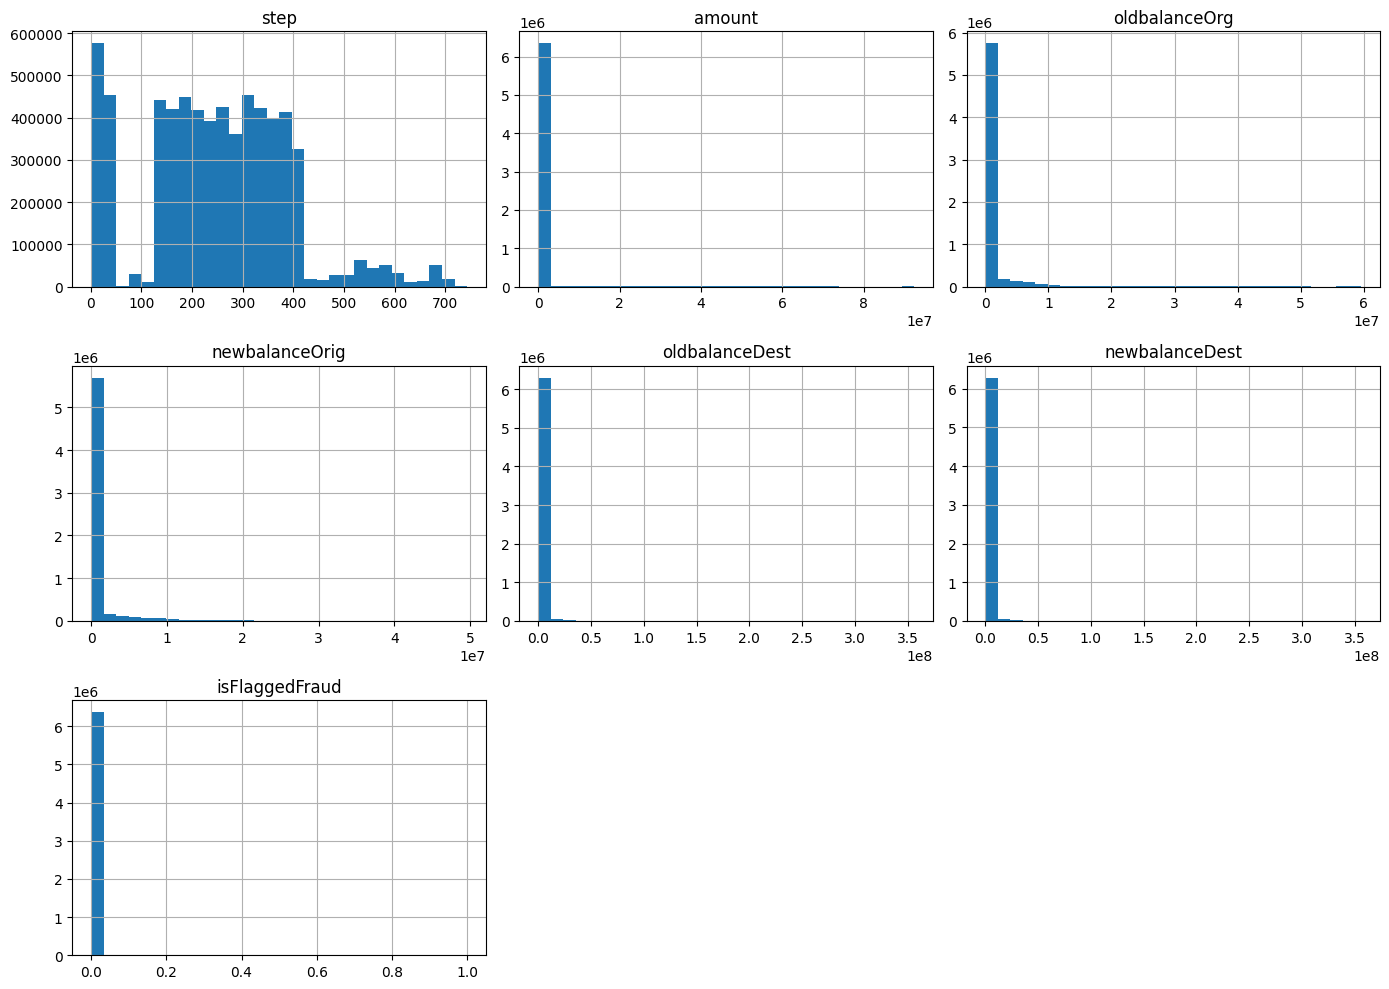

In [12]:
df[num_cols].hist(figsize=(14,10), bins=30)
plt.tight_layout()
plt.show()

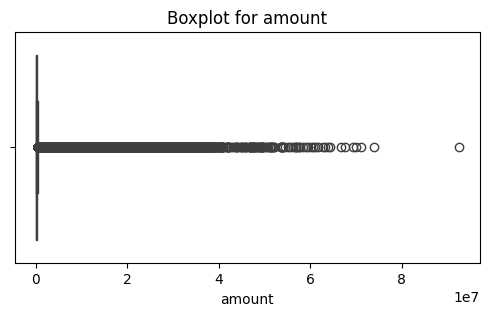

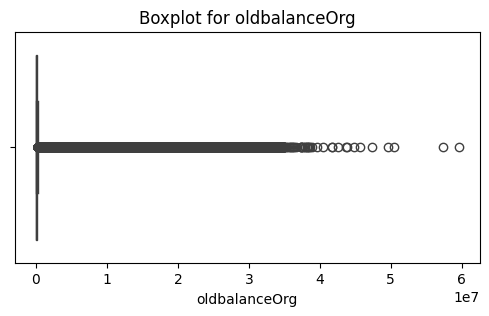

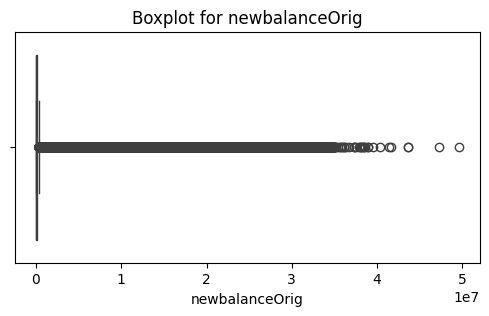

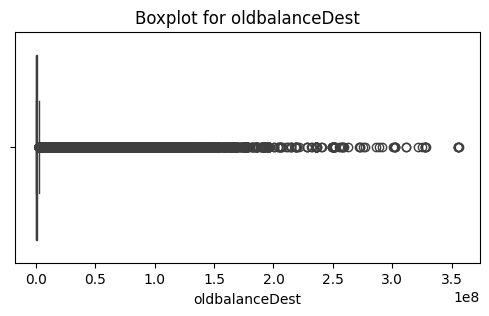

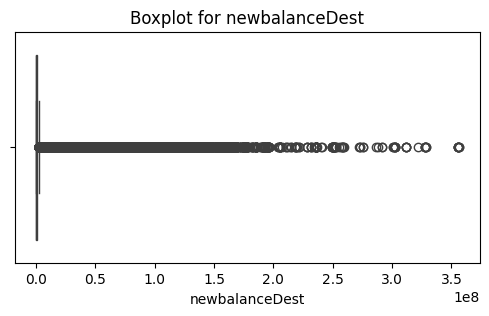

In [13]:
# Boxplots for obvious numeric columns to spot extreme outliers
for c in ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    if c in df.columns:
        plt.figure(figsize=(6,3))
        sns.boxplot(x=df[c].replace([np.inf, -np.inf], np.nan))
        plt.title(f"Boxplot for {c}")
        plt.show()

# 3) Exploratory Data Analysis (EDA)

In [14]:
# Check missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


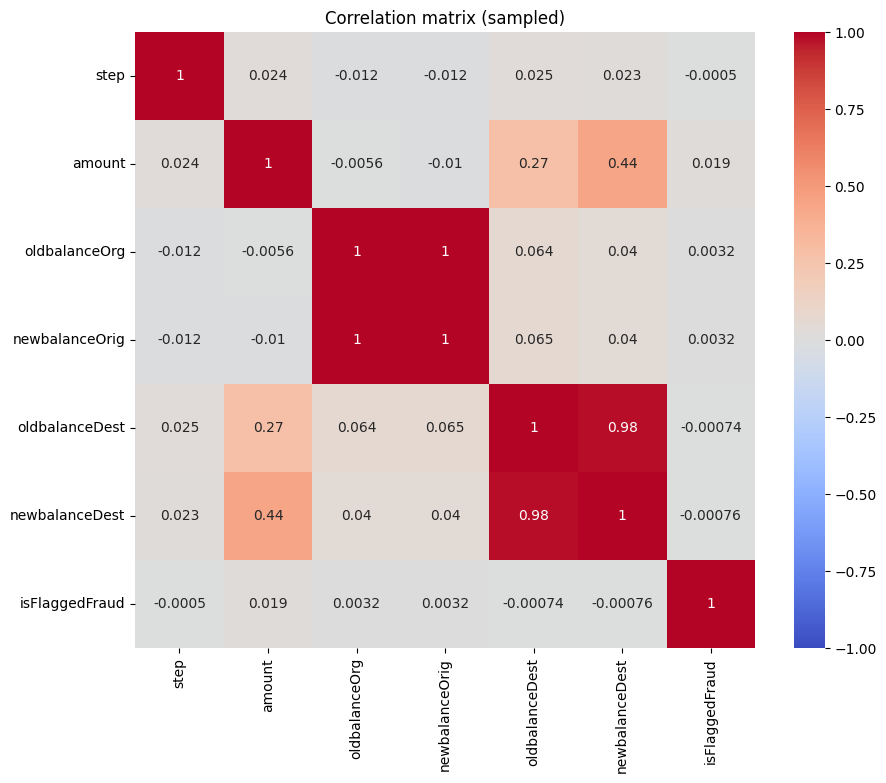

In [15]:
# Check correlations (sample if large)

corr_sample = df[num_cols].sample(min(200000, len(df)), random_state=SEED)
plt.figure(figsize=(10,8))
sns.heatmap(corr_sample.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation matrix (sampled)")
plt.show()


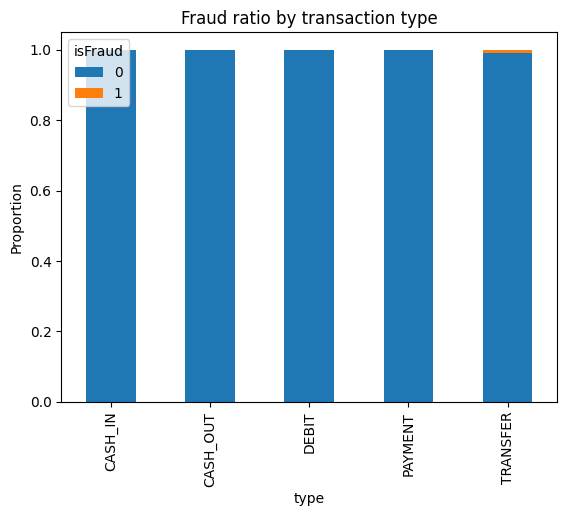

In [16]:
# Frauds by transaction type (if 'type' exists) or other categorical vars

if 'type' in df.columns:
    pd.crosstab(df['type'], df[target_col], normalize='index').plot(kind='bar', stacked=True)
    plt.title('Fraud ratio by transaction type')
    plt.ylabel('Proportion')
    plt.show()


# 4) Handle class imbalance

In [17]:
# Huge imbalance typical. Count:
print("Class counts:", Counter(df[target_col]))

Class counts: Counter({0: 6354407, 1: 8213})


In [18]:
# Strategy options:
#  - Use SMOTE after train/test split on training set only.
#  - Use class_weight where supported (e.g., LogisticRegression, RandomForest via class_weight='balanced').
#  - Downsample majority class or upsample minority using SMOTE. For large dataset, consider downsampling to manageable size.

# 5) Outlier detection & removal (check and remove outliers)

In [19]:
# Outlier removal must be done cautiously in fraud detection. We'll mark extreme transactions (IQR)

from scipy import stats

def remove_outliers_iqr(df_in, columns, factor=3.0):
    df_out = df_in.copy()
    for col in columns:
        if col in df_out.columns:
            Q1 = df_out[col].quantile(0.25)
            Q3 = df_out[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - factor * IQR
            upper = Q3 + factor * IQR
            # We do not drop rows where target==1 (fraud) to avoid throwing away rare positives; instead drop only if target==0
            mask = ~((df_out[col] < lower) | (df_out[col] > upper) & (df_out[target_col] == 0))
            df_out = df_out[mask]
    return df_out


In [20]:
# Choose numeric columns to consider for outliers removal:

candidate_out_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

candidate_out_cols = [c for c in candidate_out_cols if c in df.columns]

print("Considering outlier removal on:", candidate_out_cols)
df_clean = remove_outliers_iqr(df, candidate_out_cols, factor=3.0) # factor - 0.3 iqr value used for larger data

print("Shape before/after outlier removal:", df.shape, df_clean.shape)
# Use df_clean forward (or choose not to remove if too aggressive)
df = df_clean.copy()

Considering outlier removal on: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
Shape before/after outlier removal: (6362620, 11) (4074394, 11)


In [21]:
df.shape

(4074394, 11)

In [22]:
# Check missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


# 6) Data preprocessing / Feature engineering

In [23]:
 # -   handle missing values
#    - encode categorical variables
#    - feature creation / transformation

In [24]:
# 6.1 Handle missing values

print("Missing values before:", df.isnull().sum())

# Simple strategy: fill numeric NaN with median, categorical with 'missing'

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# check if traget col present then remove it
if target_col in num_cols:
    num_cols.remove(target_col)

# selects categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()


Missing values before: step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


if there was missing values present then we can use these code

In [25]:
# if there was missing values present then we can use these code

# Fill numeric and categorical
for col in num_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)
for col in cat_cols:
    if df[col].isnull().any():
        df[col].fillna('missing', inplace=True)

print("Missing values after:", df.isnull().sum().sum())

Missing values after: 0


# 6.2 Feature creation: example features useful for PaySim

**Why this is useful:**

**These new features can reveal suspicious behavior:**

**In a normal transaction,**

orig_net_change ≈ -amount

dest_net_change ≈ +amount

**In fraudulent transactions, balances might not match up properly —**
**for example:**

Sender balance didn’t decrease

Receiver balance didn’t increase as expected

** Possible fraud signal 🚨**

In [26]:
# 6.2 Feature creation: example features useful for PaySim

# Sender’s balance change

if set(['oldbalanceOrg','newbalanceOrig','amount']).issubset(df.columns):
    df['orig_net_change'] = df['newbalanceOrig'] - df['oldbalanceOrg']


# Receiver’s balance change

if set(['oldbalanceDest','newbalanceDest','amount']).issubset(df.columns):
    df['dest_net_change'] = df['newbalanceDest'] - df['oldbalanceDest']

**🚨 Why these ratios are useful in fraud detection**

**Fraudulent transactions often have abnormal ratios:**

Fraudsters may send a very high fraction of their balance (e.g., >0.9)

Or, a receiver’s balance may suddenly spike unusually (e.g., ratio > 10)

Such ratios help the ML model identify unusual financial behaviors.

In [27]:
# Ratio features (avoid division by zero)
def safe_div(a,b):
    return np.where(b==0, 0, a/b)
if 'amount' in df.columns:
    if 'oldbalanceOrg' in df.columns:
        df['amount_to_oldbal_orig'] = safe_div(df['amount'], df['oldbalanceOrg'])
    if 'oldbalanceDest' in df.columns:
        df['amount_to_oldbal_dest'] = safe_div(df['amount'], df['oldbalanceDest'])

In [28]:
# Convert timestamps or create time features if present (e.g., 'step' in PaySim is time step)

if 'step' in df.columns:
    df['hour'] = (df['step'] % 24).astype(int)
    df['day'] = (df['step'] // 24).astype(int)


In [29]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,orig_net_change,dest_net_change,amount_to_oldbal_orig,amount_to_oldbal_dest,hour,day
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,-1864.28,0.0,0.087735,0.000000,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,-181.00,0.0,1.000000,0.000000,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,-181.00,-21182.0,1.000000,0.008545,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,-11668.14,0.0,0.280795,0.000000,1,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0,-7817.71,0.0,0.145149,0.000000,1,0


In [30]:
# Drop high-cardinality ID columns before encoding
df = df.drop(columns=['nameOrig', 'nameDest'], errors='ignore')

In [31]:
df.head(5)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,orig_net_change,dest_net_change,amount_to_oldbal_orig,amount_to_oldbal_dest,hour,day
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,-1864.28,0.0,0.087735,0.000000,1,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,-181.00,0.0,1.000000,0.000000,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,-181.00,-21182.0,1.000000,0.008545,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,-11668.14,0.0,0.280795,0.000000,1,0
5,1,PAYMENT,7817.71,53860.0,46042.29,0.0,0.0,0,0,-7817.71,0.0,0.145149,0.000000,1,0


In [32]:
# Check missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
step                     0
type                     0
amount                   0
oldbalanceOrg            0
newbalanceOrig           0
oldbalanceDest           0
newbalanceDest           0
isFraud                  0
isFlaggedFraud           0
orig_net_change          0
dest_net_change          0
amount_to_oldbal_orig    0
amount_to_oldbal_dest    0
hour                     0
day                      0
dtype: int64


# 6.3 Categorical encoding

In [33]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# Select small categorical features
categorical_features = [c for c in ['type'] if c in df.columns]

# Fit-transform categorical columns
encoded_array = ohe.fit_transform(df[categorical_features])

# Create encoded DataFrame with correct index
encoded_df = pd.DataFrame(
    encoded_array,
    columns=ohe.get_feature_names_out(categorical_features),
    index=df.index  # important fix!
)

# Concatenate encoded columns back
df = pd.concat([df.drop(columns=categorical_features), encoded_df], axis=1)

print("After encoding:")
print(df.shape)
print(df.columns[:10])


After encoding:
(4074394, 18)
Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'orig_net_change',
       'dest_net_change'],
      dtype='object')


In [34]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,orig_net_change,dest_net_change,amount_to_oldbal_orig,amount_to_oldbal_dest,hour,day,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,-1864.28,0.0,0.087735,0.000000,1,0,0.0,0.0,1.0,0.0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,-181.00,0.0,1.000000,0.000000,1,0,0.0,0.0,0.0,1.0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,-181.00,-21182.0,1.000000,0.008545,1,0,1.0,0.0,0.0,0.0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,-11668.14,0.0,0.280795,0.000000,1,0,0.0,0.0,1.0,0.0
5,1,7817.71,53860.0,46042.29,0.0,0.0,0,0,-7817.71,0.0,0.145149,0.000000,1,0,0.0,0.0,1.0,0.0


In [35]:
# Check missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
step                     0
amount                   0
oldbalanceOrg            0
newbalanceOrig           0
oldbalanceDest           0
newbalanceDest           0
isFraud                  0
isFlaggedFraud           0
orig_net_change          0
dest_net_change          0
amount_to_oldbal_orig    0
amount_to_oldbal_dest    0
hour                     0
day                      0
type_CASH_OUT            0
type_DEBIT               0
type_PAYMENT             0
type_TRANSFER            0
dtype: int64


In [36]:
df.columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'orig_net_change',
       'dest_net_change', 'amount_to_oldbal_orig', 'amount_to_oldbal_dest',
       'hour', 'day', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER'],
      dtype='object')

# 7) Train/test split

In [37]:
target_col = 'isFraud'
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols]
y = df[target_col]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)
print("Train distribution:", Counter(y_train), "Test distribution:", Counter(y_test))

Train distribution: Counter({0: 3252945, 1: 6570}) Test distribution: Counter({0: 813236, 1: 1643})


# 8) Dealing with class imbalance: SMOTE on training set

In [38]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Before SMOTE train shape:", X_train.shape, Counter(y_train))
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric features count:", len(numeric_features))

smote = SMOTE(random_state=SEED)
X_train_num = X_train[numeric_features].copy()
X_res, y_res = smote.fit_resample(X_train_num, y_train)
print("After SMOTE:", X_res.shape, Counter(y_res))


Before SMOTE train shape: (3259515, 17) Counter({0: 3252945, 1: 6570})
Numeric features count: 17
After SMOTE: (6505890, 17) Counter({0: 3252945, 1: 3252945})


# 9) Model selection & training
- baseline logistic regression (weighted)
- RandomForest
- XGBoost

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# --- Train Logistic Regression on SMOTE-balanced data ---
print("Training LogisticRegression after SMOTE...")

lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=SEED, max_iter=1000))
])

# Train on SMOTE-balanced data
lr_pipe.fit(X_res, y_res)

# Predict on original (unbalanced) test set
y_pred_lr = lr_pipe.predict(X_test[numeric_features])

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, digits=4))

# ROC-AUC
y_proba_lr = lr_pipe.predict_proba(X_test[numeric_features])[:, 1]
print("LR ROC-AUC:", roc_auc_score(y_test, y_proba_lr))


Training LogisticRegression after SMOTE...
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9928    0.9962    813236
           1     0.1875    0.8198    0.3052      1643

    accuracy                         0.9925    814879
   macro avg     0.5936    0.9063    0.6507    814879
weighted avg     0.9980    0.9925    0.9948    814879

LR ROC-AUC: 0.9921217934962933


In [40]:
#  Random Forest
# =============================
print("\nTraining Random Forest (on SMOTE-balanced data)...")

rf = RandomForestClassifier(
    n_estimators=200,
    n_jobs=-1,
    random_state=SEED
)
rf.fit(X_res, y_res)
y_pred_rf = rf.predict(X_test[numeric_features])
y_proba_rf = rf.predict_proba(X_test[numeric_features])[:, 1]
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf, digits=4))
print("RF ROC-AUC:", roc_auc_score(y_test, y_proba_rf))



Training Random Forest (on SMOTE-balanced data)...
Random Forest Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    813236
           1     0.9927    0.9982    0.9954      1643

    accuracy                         1.0000    814879
   macro avg     0.9964    0.9991    0.9977    814879
weighted avg     1.0000    1.0000    1.0000    814879

RF ROC-AUC: 0.9996918003201246


In [45]:
# XGBoost (Baseline)
# =============================
print("\nTraining baseline XGBoost...")

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

n_pos = sum(y_train == 1)
n_neg = sum(y_train == 0)
scale_pos_weight = n_neg / (n_pos + 1e-9)

xgb = XGBClassifier(
   random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6
)
xgb.fit(X_train[numeric_features], y_train)
y_pred_xgb = xgb.predict(X_test[numeric_features])
y_proba_xgb = xgb.predict_proba(X_test[numeric_features])[:, 1]
print("Baseline XGBoost Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))


Training baseline XGBoost...
Baseline XGBoost Report:
              precision    recall  f1-score   support

           0     1.0000    0.9996    0.9998    813236
           1     0.8314    0.9963    0.9064      1643

    accuracy                         0.9996    814879
   macro avg     0.9157    0.9980    0.9531    814879
weighted avg     0.9997    0.9996    0.9996    814879

XGBoost ROC-AUC: 0.9999113630294147


In [46]:
# =============================
# STEP 7: XGBoost (Tuned)
# =============================
print("\nTuning XGBoost hyperparameters (RandomizedSearchCV)...")

param_dist = {
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 3, 5]
}

tune_sample_frac = 0.1
X_train_tune = X_train.sample(frac=tune_sample_frac, random_state=SEED)
y_train_tune = y_train.loc[X_train_tune.index]

xgb_base = XGBClassifier(
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)

search = RandomizedSearchCV(
    xgb_base, param_distributions=param_dist,
    n_iter=15, scoring='roc_auc',
    n_jobs=-1, cv=3, verbose=1, random_state=SEED
)
search.fit(X_train_tune[numeric_features], y_train_tune)

best_xgb = search.best_estimator_
print("\nBest XGBoost params:", search.best_params_)

# Evaluate tuned XGBoost
y_pred_best = best_xgb.predict(X_test[numeric_features])
y_proba_best = best_xgb.predict_proba(X_test[numeric_features])[:, 1]
print("Tuned XGBoost Report:")
print(classification_report(y_test, y_pred_best, digits=4))
print("Tuned XGBoost ROC-AUC:", roc_auc_score(y_test, y_proba_best))


Tuning XGBoost hyperparameters (RandomizedSearchCV)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best XGBoost params: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.7}
Tuned XGBoost Report:
              precision    recall  f1-score   support

           0     1.0000    0.9998    0.9999    813236
           1     0.9065    0.9976    0.9499      1643

    accuracy                         0.9998    814879
   macro avg     0.9533    0.9987    0.9749    814879
weighted avg     0.9998    0.9998    0.9998    814879

Tuned XGBoost ROC-AUC: 0.9999171939757623



=== Tuned XGBoost Evaluation ===
              precision    recall  f1-score   support

           0     1.0000    0.9998    0.9999    813236
           1     0.9065    0.9976    0.9499      1643

    accuracy                         0.9998    814879
   macro avg     0.9533    0.9987    0.9749    814879
weighted avg     0.9998    0.9998    0.9998    814879

ROC-AUC: 0.9999171939757623
Precision: 0.9065265486725663
Recall: 0.9975654290931223
F1: 0.9498696030136192


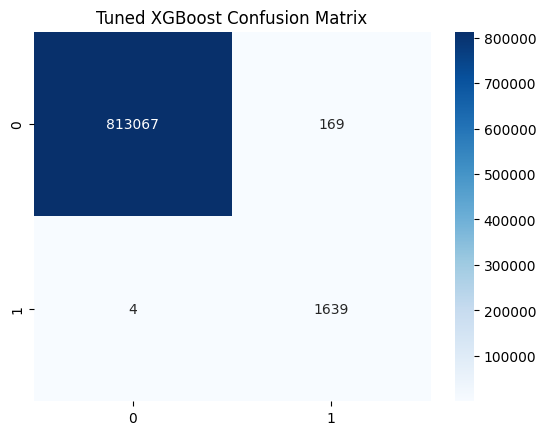

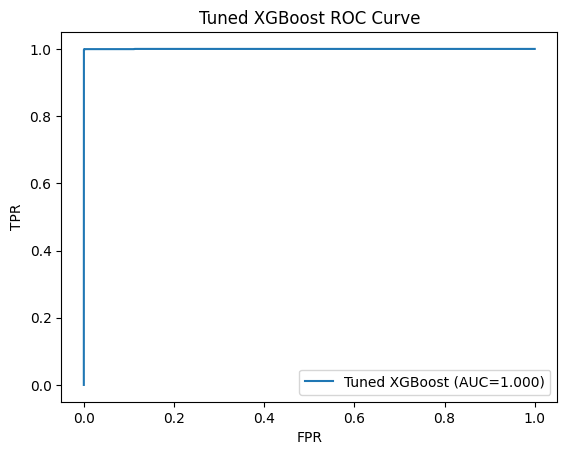

In [47]:
# =============================
# STEP 8: Evaluation Function
# =============================

from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score


def eval_model(y_true, y_pred, y_proba, model_name="Model"):
    print(f"\n=== {model_name} Evaluation ===")
    print(classification_report(y_true, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1:", f1_score(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc_score(y_true, y_proba):.3f})")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"{model_name} ROC Curve")
    plt.legend()
    plt.show()

# Evaluate final tuned model
eval_model(y_test, y_pred_best, y_proba_best, "Tuned XGBoost")


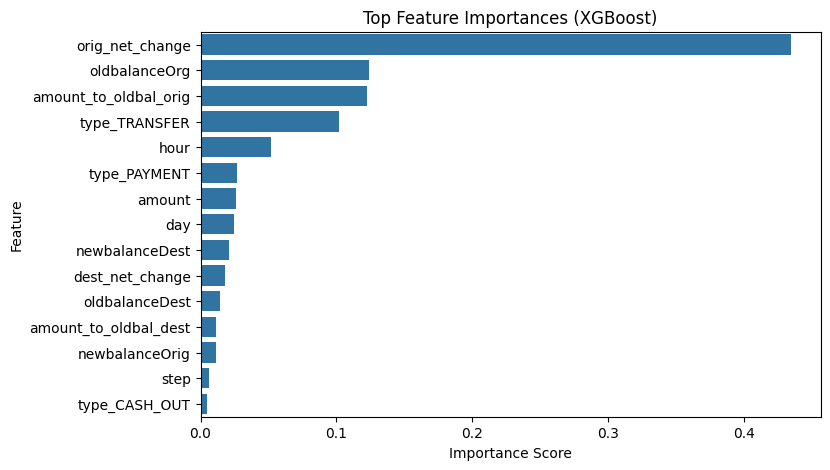

In [50]:
# =============================
# STEP 9: Feature Importance + SHAP
# =============================

# --- Feature Importances ---
if hasattr(best_xgb, 'feature_importances_'):
    importances = pd.Series(best_xgb.feature_importances_, index=numeric_features)
    top_feats = importances.sort_values(ascending=False).head(15)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=top_feats.values, y=top_feats.index)
    plt.title("Top Feature Importances (XGBoost)")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()



In [53]:
# =============================
# STEP 10: Save Model
# =============================
import joblib

MODEL_PATH = "final_model.joblib"
joblib.dump(best_xgb, MODEL_PATH)
print(f"✅ Model saved to {MODEL_PATH}")

# =============================
# STEP 11: Predict Function
# =============================
def predict_transaction(model, df_row, numeric_features=numeric_features, threshold=0.5):
    """
    Predict fraud probability for a single transaction row
    """
    proba = model.predict_proba(df_row[numeric_features])[:, 1][0]
    fraud_flag = int(proba >= threshold)
    return {"fraud_probability": proba, "is_fraud": fraud_flag}

# Example usage:
sample_row = X_test.sample(1, random_state=SEED)
print("\nPrediction for a random transaction:")
print(predict_transaction(best_xgb, sample_row))


✅ Model saved to final_model.joblib

Prediction for a random transaction:
{'fraud_probability': np.float32(9.368969e-05), 'is_fraud': 0}



=== Model Comparison ===
                 Model   ROC-AUC  Precision    Recall        F1
0  Logistic Regression  0.992122   0.187474  0.819842  0.305165
1        Random Forest  0.999692   0.992736  0.998174  0.995448
2      XGBoost (Tuned)  0.999917   0.906527  0.997565  0.949870


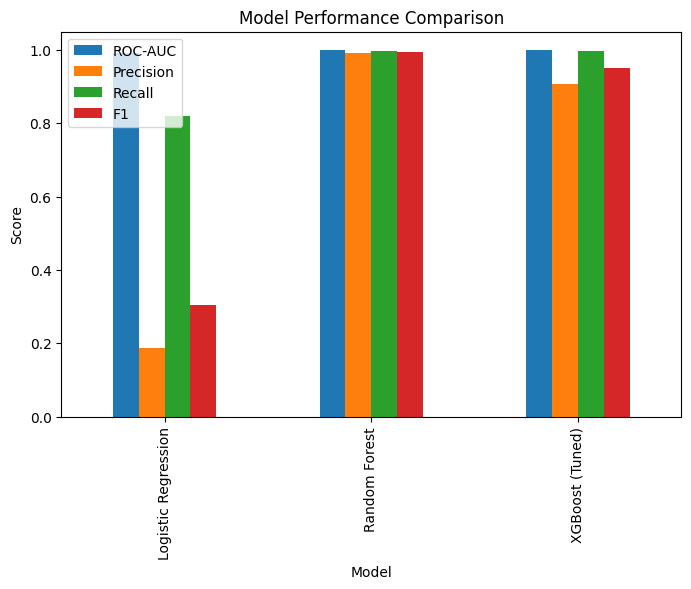

In [54]:
# STEP 12: Compare All Models
# =============================
models = {
    "Logistic Regression": (y_test, y_pred_lr, y_proba_lr),
    "Random Forest": (y_test, y_pred_rf, y_proba_rf),
    "XGBoost (Tuned)": (y_test, y_pred_best, y_proba_best)
}

results = []
for name, (yt, yp, yp_prob) in models.items():
    results.append({
        "Model": name,
        "ROC-AUC": roc_auc_score(yt, yp_prob),
        "Precision": precision_score(yt, yp),
        "Recall": recall_score(yt, yp),
        "F1": f1_score(yt, yp)
    })

results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df)

# Bar plot comparison
results_df.set_index("Model").plot(kind="bar", figsize=(8, 5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.show()

**Which is the best model?**

XGBoost (Tuned) is the best-balanced model for fraud detection.

**Why:**

ROC-AUC = 0.9999, almost perfect class separation.

Recall = 0.9975, meaning it catches ~99.8% of actual frauds — this is critical for fraud detection.

Precision = 0.907, meaning ~91% of flagged transactions are truly frauds — still very high.

F1 = 0.95, excellent balance between recall and precision.

👉 It’s the most practical and generalizable model: strong recall (few missed frauds), good precision (few false alarms), and robust learning from features.

✅ XGBoost generalizes better.

⚠️ Random Forest likely memorized the training set → overfit.

⚖️ Logistic Regression underfits (too simple, low precision).